In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from cellpose import io
from ResNet_HelperFunctions import *
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
control_dir = '../control_images/'
drug_dir = '../drug_images/'

control_fnames = [control_dir + fname for fname in os.listdir(control_dir)]
drug_fnames = [drug_dir + fname for fname in os.listdir(drug_dir)]

In [4]:
#ds = Dataset(control_fnames, drug_fnames)
#_ = ds.createImageDataset(final_size=224)

cell_data = LoadImageDataset('pytorch_dataset/cells/')
nucleus_data = LoadImageDataset('pytorch_dataset/nuclei/')

In [5]:
from torch.utils.data import DataLoader, random_split

train_data, val_data = random_split(nucleus_data, [0.8, 0.2])
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [6]:
n_epochs = 10
epochs = np.arange(0, n_epochs+0.5, dtype=int)
times = np.linspace(n_epochs, 0, n_epochs * len(train_dataloader), endpoint=False)[::-1]

clf_2k = Resnet18(train_layers=2).to(device)
clf_500k = Resnet18(train_layers=4).to(device)
clf_3M = Resnet18(train_layers=6).to(device)
clf_12M = Resnet18(train_layers=int(1e8)).to(device)

/home/amaschio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amaschio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/61 [00:00<?, ?it/s]/home/amaschio/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 0/61 [00:00<?, ?it/s]/home/amaschio/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 0/61 [00:00<?, ?it/s]/home/amaschio/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 0/61 [00:00<?, ?it/s]/home/amaschio/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit d

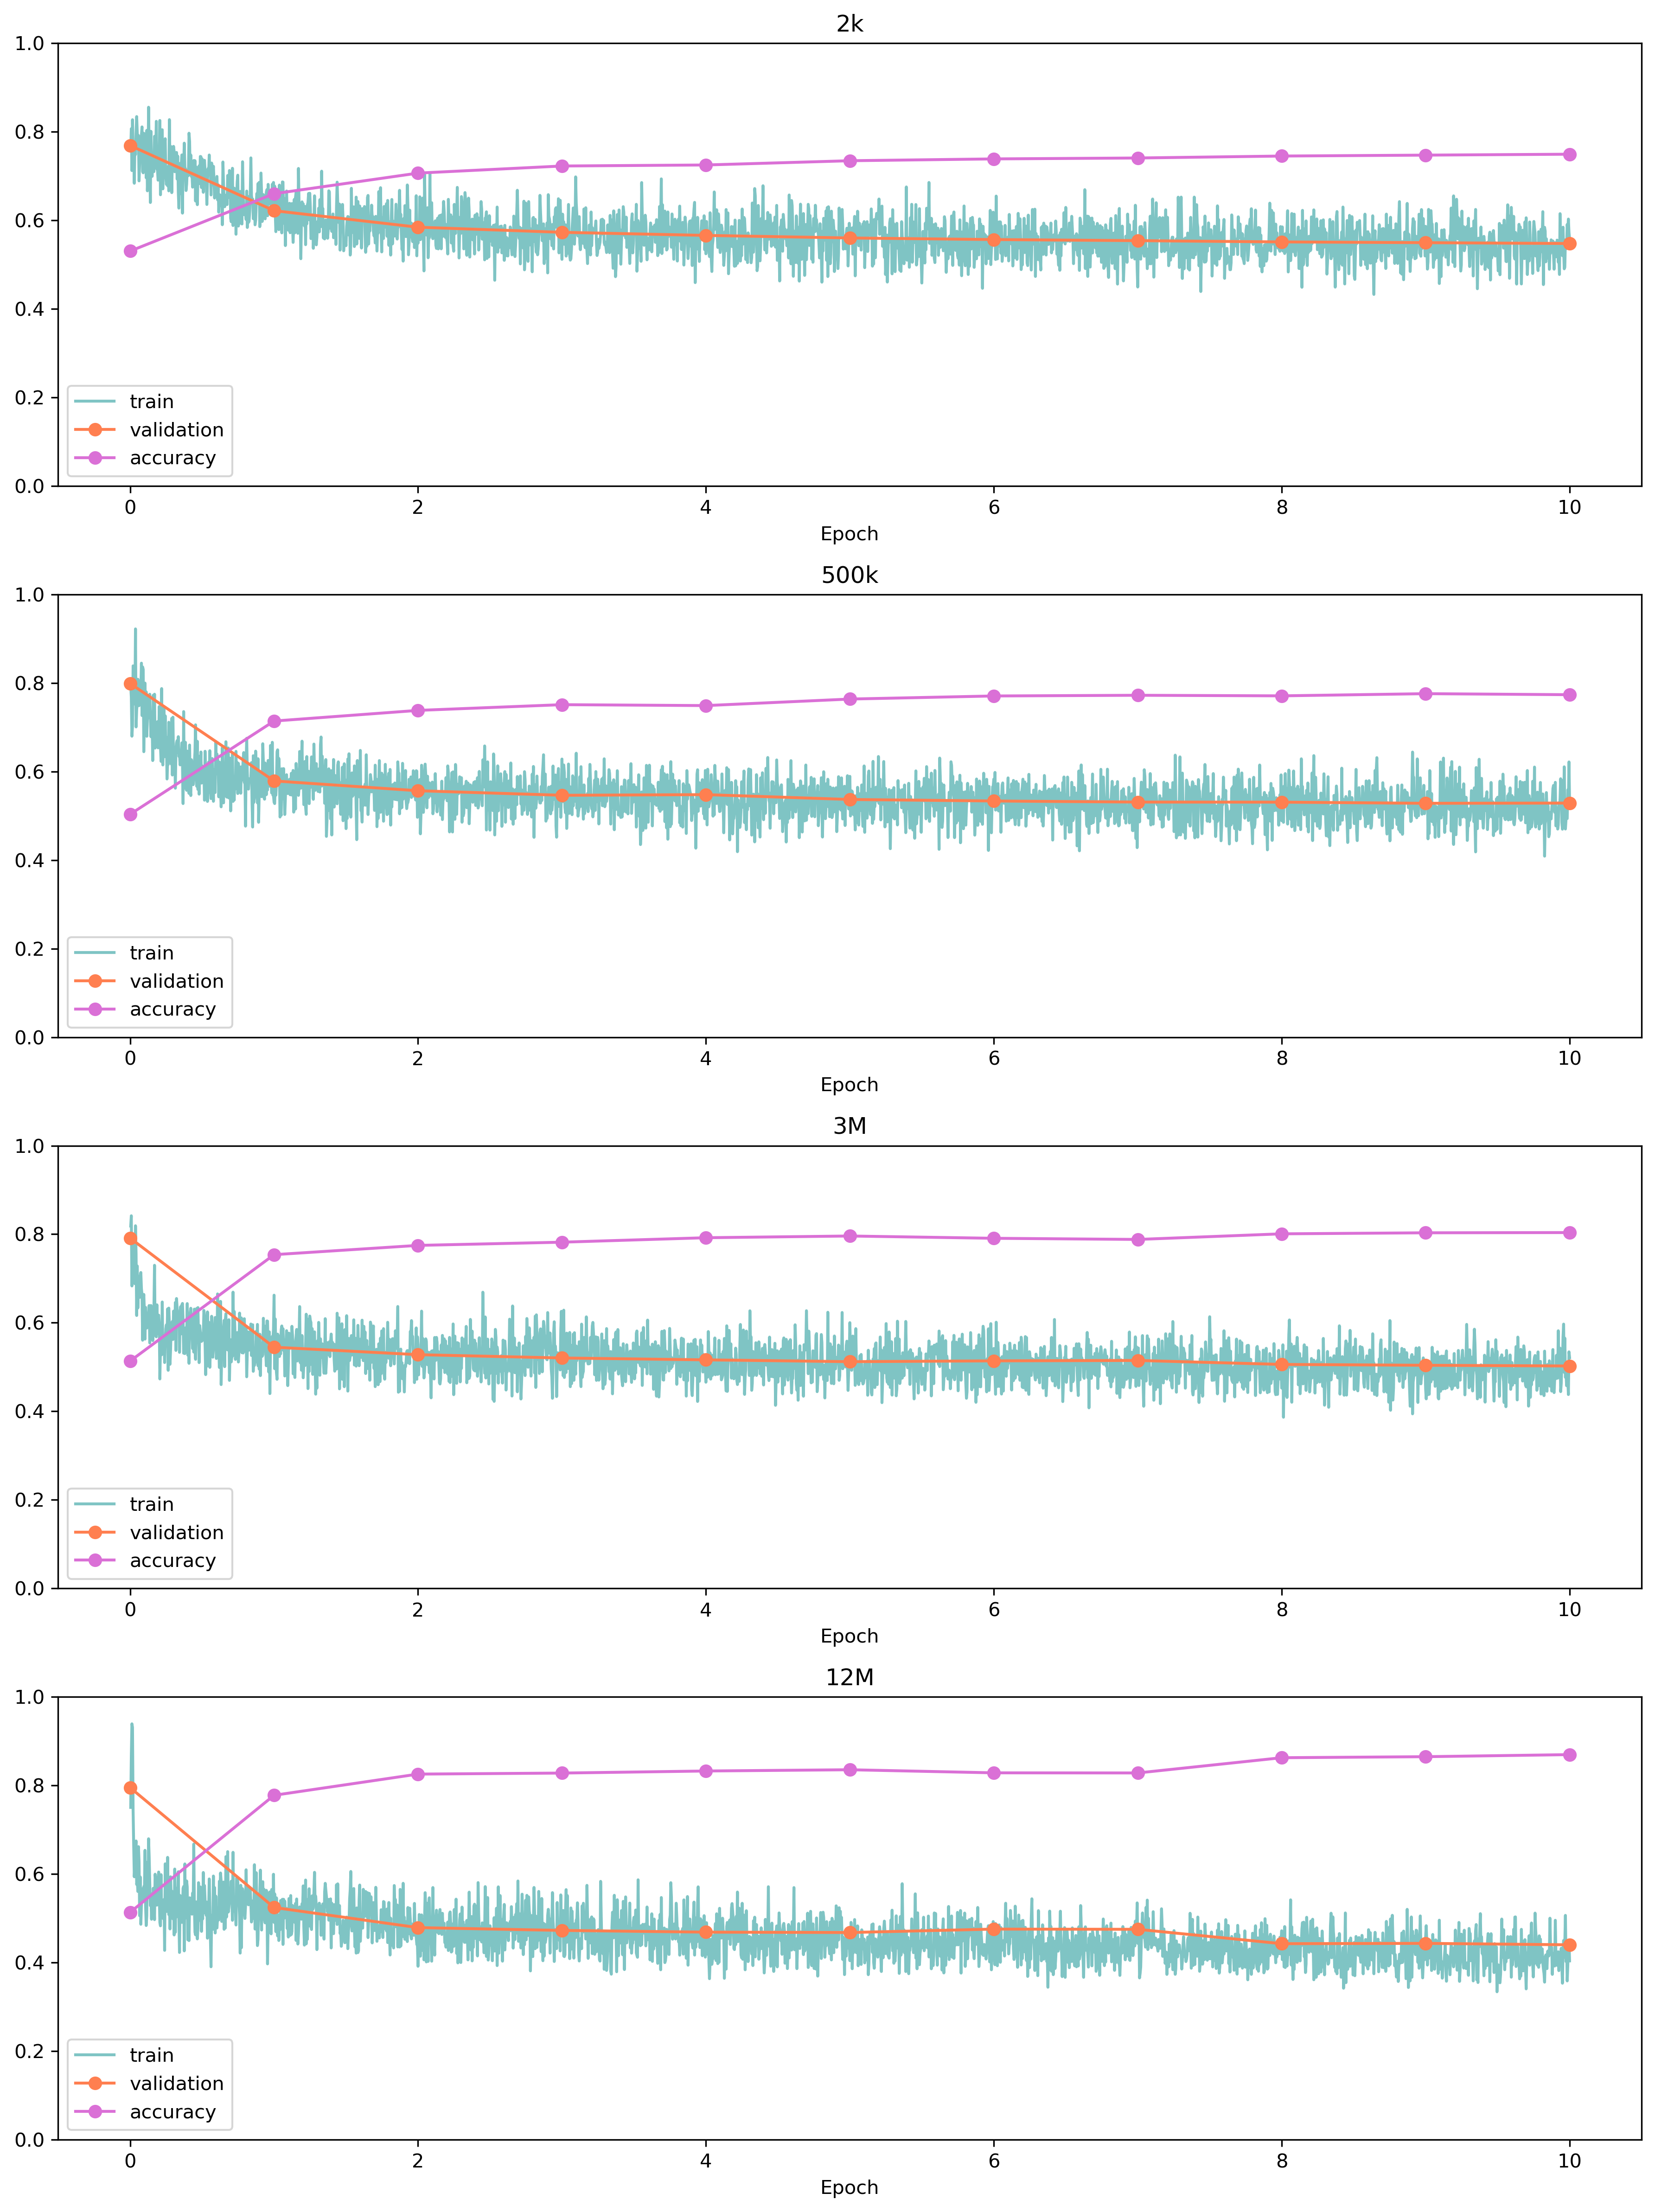

In [7]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

fig, axes = plt.subplots(4, 1, figsize=(12,16), dpi=300)

for ax, clf, name in zip(axes.flatten(), [clf_2k, clf_500k, clf_3M, clf_12M], ['2k', '500k', '3M', '12M']):
    
    loss_fn = CrossEntropyLoss()
    opt = Adam(clf.parameters(), lr=1e-5)

    start_val, start_acc = apply_val(clf, val_dataloader, loss_fn, device=device)

    train_losses = []
    val_losses = [start_val]
    val_acc = [start_acc]

    for _ in range(n_epochs):
        for X, y in tqdm(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = clf(X)
            loss = loss_fn(y_pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_losses.append(loss.item())
        val, acc = apply_val(clf, val_dataloader, loss_fn, device=device)
        val_losses.append(val)
        val_acc.append(acc)

    ax.set_title(name)
    ax.plot(times, train_losses, '-', c='darkcyan', label='train', alpha=0.5)
    ax.plot(epochs, val_losses, '-o', c='coral', label='validation')
    ax.plot(epochs, val_acc, '-o', c='orchid', label='accuracy')

    ax.set_xlim(-0.5, n_epochs+0.5); ax.set_ylim(0, 1)
    ax.set_xlabel('Epoch')
    ax.legend(loc='lower left')

plt.tight_layout()
plt.savefig('../figures/resnet_benchmarks.png', dpi=300, bbox_inches='tight')
plt.show()